# XRF Spectral Data-Preprocessing
In this notebook, we:<br>
* Perform a running sum on the spectra from the raw XRF data to increase the signal to noise ratio <br>
* Export the data so that it can be reduced in Q-Spec, the ITRAX software.<br>
* Reimport the data and putt XRF element intensities on a depth scale, selecting only the splice intervals<br>

This step is necessitated by noisy data produced by such short rapid exposure times

# Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
import os
import shutil

# Set Paths for Cores
The 10 GB of raw data are located on an external hardrive, this link will not work on github.

In [2]:
U1474='/Users/danielbabin/Documents/GitHub/U1474_XRF_Data_Report/Data/EXP361-U1474/'

# Get Core Names
I'll need to link to a directory in each core's file that has the raw spectra files

In [170]:
U1474_sections=listdir(U1474)
U1474_sections.sort()
U1474_sections=U1474_sections[1:]

# Pre-Process Data
The steps for each core section (213 in all):<br>
1) Load all files in the section's directory as dataframes into a dictionary. <br>
2) Turn that dictionary into a single dataframe, where each column is one of the spectra. <br>
3) Do a 10-pt running sum of those spectra and selected every 10th one. This turns 10 spectra into one taller one. <br>
4) Turn that dataframe back into a a dictionary and a csv that Qspec can read.<br>
5) Write the resulting file into a directory on the external hardrive called 'New XRF Data"<br>
## U1474

In [316]:
all_results_path='/Users/danielbabin/Documents/GitHub/U1474_XRF_Data_Report/Data/New_XRF_Data/'

### Collect Non-Problematic Sections

In [317]:
main=pd.DataFrame(U1474_sections)
main=main[(main.index!=18)&(main.index!=54)&(main.index!=82)&(main.index!=83)]
main=main[0].to_list()

### Investigate Range of Normal Total Signals

In [241]:
section_intensities={}
for section in main: 
    core=U1474+section+'/XRF data/'

    files=listdir(core)
    files.sort()

    dct={}
    for file in files:
        dct[file]=pd.read_csv(core+file,sep='\t',index_col='Date:')

    df=pd.DataFrame()
    for k in dct.keys():
        df[k]=dct[k].iloc[30:,0].astype(int)

    section_intensities[section]=df.sum()

In [274]:
df_si=pd.DataFrame(index=np.arange(0,800))
for k in section_intensities.keys():
    df_si.loc[:len(section_intensities[k])-1,k]=section_intensities[k].values

Text(0, 0.5, 'Total Signal (cts)')

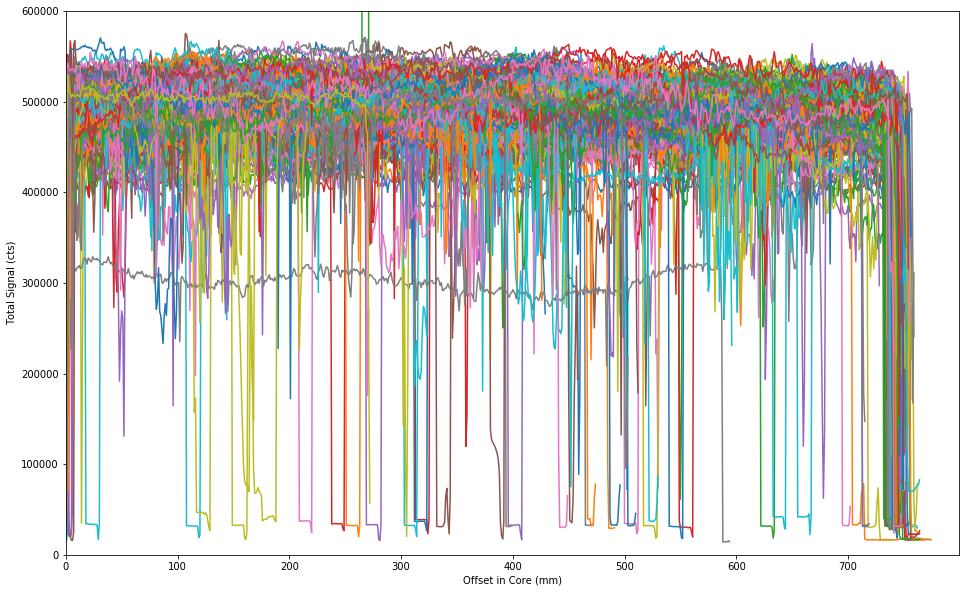

In [315]:
fig,ax=plt.subplots(figsize=(16,10))
for col in df_si.columns:
    df_si[col].plot(ax=ax)
ax.set_ylim(0,6e5)
ax.set_xlabel('Offset in Core (mm)')
ax.set_ylabel('Total Signal (cts)')

## Pre-Process Non-Problem Sections

In [340]:
for section in main: 
    core=U1474+section+'/XRF data/'

    files=listdir(core)
    files.sort()

    dct={}
    for file in files:
        dct[file]=pd.read_csv(core+file,sep='\t',index_col='Date:')

    df=pd.DataFrame()
    for k in dct.keys():
        df[k]=dct[k].iloc[30:,0].astype(int)
    
    cleaned=df.loc[:,(df.sum()>100000)&(df.sum()<600000)]

    sumspectra=cleaned.sum(axis=1)
    ss_product=dct['L000000.spe']
    ss_product.iloc[30:,0]=sumspectra

    ss_path='/Users/danielbabin/Documents/GitHub/U1474_XRF_Data_Report/Data/EXP361-U1474/'+section
    ss_product.to_csv(ss_path+'/sumspectra.spe',sep='\t')

    run_summed=cleaned.rolling(10,center=True,axis=1).sum()

    selected=run_summed.iloc[:,5:-5:10].copy()
    colnames=run_summed.iloc[:,:-10:10].columns
    for i,col in enumerate(selected.columns):
        selected.rename(columns={col:colnames[i]},inplace=True)

    product_dict={}
    for i in selected.columns.to_list():
        product_dict[i]=dct[i]
        product_dict[i].iloc[30:,0]=selected[i]

    for key in product_dict:
        product_dict[key].to_csv(all_results_path+section+'-'+key,sep='\t')

### Super Sum Spectra

In [341]:
dct={}
for section in main: 
    file=U1474+section+'/sumspectra.spe'
    dct[section]=pd.read_csv(file,sep='\t',index_col='Date:')
    
df=pd.DataFrame()
for k in dct.keys():
    df[k]=dct[k].iloc[30:,0].astype(float)
    
dfm=df.sum(axis=1)/213

In [342]:
product=dct['000_U1474F_1H1']
product.iloc[30:,0]=dfm

results_path='/Users/danielbabin/Documents/GitHub/U1474_XRF_Data_Report/Data/EXP361-U1474/'
product.to_csv(results_path+'meanspectra.spe',sep='\t')

### Exception Sections

#### D4H1

In [351]:
i=18
section=U1474_sections[i]
core=U1474+section+'/XRF data/'

files=listdir(core)
files.sort()

dct={}
for file in files[:-1]:
    dct[file]=pd.read_csv(core+file,sep='\t',index_col='Date:')

df=pd.DataFrame()
for k in dct.keys():
    df[k]=dct[k].iloc[30:,0].astype(int)

cleaned=df.loc[:,(df.sum()>60000)]
cleaned=cleaned[sorted(cleaned.columns.to_list())]

sumspectra=cleaned.sum(axis=1)
ss_product=dct['L000000.spe']
ss_product.iloc[30:,0]=sumspectra

ss_path='/Users/danielbabin/Documents/GitHub/U1474_XRF_Data_Report/Data/EXP361-U1474/'+section
ss_product.to_csv(ss_path+'/sumspectra.spe',sep='\t')

run_summed=cleaned.rolling(10,center=True,axis=1).sum()

selected=run_summed.iloc[:,5:-5:10].copy()
colnames=run_summed.iloc[:,:-10:10].columns
for i,col in enumerate(selected.columns):
    selected.rename(columns={col:colnames[i]},inplace=True)

product_dict={}
for i in selected.columns.to_list():
    product_dict[i]=dct[i]
    product_dict[i].iloc[30:,0]=selected[i]

for key in product_dict:
    product_dict[key].to_csv(all_results_path+section+'-'+key,sep='\t')

#### D8H3

In [359]:
i=54
section=U1474_sections[i]
core=U1474+section+'/XRF data/'

files=listdir(core)
files.sort()

dct={}
for file in files[:-1]:
    dct[file]=pd.read_csv(core+file,sep='\t',index_col='Date:')

df=pd.DataFrame()
for k in dct.keys():
    df[k]=dct[k].iloc[30:,0].astype(int)

cleaned=df.loc[:,(df.sum()>230000)]

sumspectra=cleaned.sum(axis=1)
ss_product=dct['L000000.spe']
ss_product.iloc[30:,0]=sumspectra

ss_path='/Users/danielbabin/Documents/GitHub/U1474_XRF_Data_Report/Data/EXP361-U1474/'+section
ss_product.to_csv(ss_path+'/sumspectra.spe',sep='\t')

run_summed=cleaned.rolling(10,center=True,axis=1).sum()

selected=run_summed.iloc[:,5:-5:10].copy()
colnames=run_summed.iloc[:,:-10:10].columns
for i,col in enumerate(selected.columns):
    selected.rename(columns={col:colnames[i]},inplace=True)

product_dict={}
for i in selected.columns.to_list():
    product_dict[i]=dct[i]
    product_dict[i].iloc[30:,0]=selected[i]

for key in product_dict:
    product_dict[key].to_csv(all_results_path+section+'-'+key,sep='\t')

#### D11H4

In [360]:
i=82
section=U1474_sections[i]
core=U1474+section+'/XRF data/'

files=listdir(core)
files.sort()

dct={}
for file in files[:-1]:
    dct[file]=pd.read_csv(core+file,sep='\t',index_col='Date:')

df=pd.DataFrame()
for k in dct.keys():
    df[k]=dct[k].iloc[30:,0].astype(int)

cleaned=df.loc[:,(df.sum()>270000)]

sumspectra=cleaned.sum(axis=1)
ss_product=dct['L000000.spe']
ss_product.iloc[30:,0]=sumspectra

ss_path='/Users/danielbabin/Documents/GitHub/U1474_XRF_Data_Report/Data/EXP361-U1474/'+section
ss_product.to_csv(ss_path+'/sumspectra.spe',sep='\t')

run_summed=cleaned.rolling(10,center=True,axis=1).sum()

selected=run_summed.iloc[:,5:-5:10].copy()
colnames=run_summed.iloc[:,:-10:10].columns
for i,col in enumerate(selected.columns):
    selected.rename(columns={col:colnames[i]},inplace=True)

product_dict={}
for i in selected.columns.to_list():
    product_dict[i]=dct[i]
    product_dict[i].iloc[30:,0]=selected[i]

for key in product_dict:
    product_dict[key].to_csv(all_results_path+section+'-'+key,sep='\t')

#### D11H5

In [362]:
# for i in [18,54,82,83]: 
i=83
section=U1474_sections[i]
core=U1474+section+'/XRF data/'

files=listdir(core)
files.sort()

dct={}
for file in files[:-1]:
    dct[file]=pd.read_csv(core+file,sep='\t',index_col='Date:')

df=pd.DataFrame()
for k in dct.keys():
    df[k]=dct[k].iloc[30:,0].astype(int)

cleaned=df.loc[:,(df.sum()>120000)]

sumspectra=cleaned.sum(axis=1)
ss_product=dct['L000000.spe']
ss_product.iloc[30:,0]=sumspectra

ss_path='/Users/danielbabin/Documents/GitHub/U1474_XRF_Data_Report/Data/EXP361-U1474/'+section
ss_product.to_csv(ss_path+'/sumspectra.spe',sep='\t')

run_summed=cleaned.rolling(10,center=True,axis=1).sum()

selected=run_summed.iloc[:,5:-5:10].copy()
colnames=run_summed.iloc[:,:-10:10].columns
for i,col in enumerate(selected.columns):
    selected.rename(columns={col:colnames[i]},inplace=True)

product_dict={}
for i in selected.columns.to_list():
    product_dict[i]=dct[i]
    product_dict[i].iloc[30:,0]=selected[i]

for key in product_dict:
    product_dict[key].to_csv(all_results_path+section+'-'+key,sep='\t')

# Results

In [501]:
data_path='/Users/danielbabin/Documents/GitHub/U1474_XRF_Data_Report/Data/'

## Import Core Depth and Identification Details
I'll need this information to turn individual core positions from the XRF scanner into total core depths and piece together the splice. 

In [502]:
splice=pd.read_csv(data_path+'U1474_splice_construction.csv').iloc[0:57]
splice['CoreLabel']=(splice['Site']+splice['Hole']+'_'+splice['Core'].map(str))

section_list=pd.read_csv(data_path+'U1474_section_list.csv')
section_list['SectionLabel']=(section_list['Site']+section_list['Hole']+'_'+
                              section_list['Core'].map(str)+section_list['Type']+section_list['Sect'].map(str))
section_list.rename(columns={'Top depth CCSF-361-U1474-ABDEF-20160220 (m)':'Top Depth CCSF (m)',
                            'Bottom depth CCSF-361-U1474-ABDEF-20160220 (m)':'Bottom Depth CCSF (m)'},inplace=True)

## Retrieve Data from Hardrive
Within this loop, I've also added section identifiers and top and bottom depths for each core. It's easy to do at this step because each dataframe is still only associated with one section. 

In [549]:
data=pd.read_csv(data_path+'Results.txt',header=2,sep='\t')

In [550]:
data['SectionFile']=data['filename'].str[29:]
data[['SectionLabel','File']]=data['SectionFile'].str[4:].str.split("-", n = 1, expand = True)
data['Core']=data['SectionLabel'].str[:-2]
data['Section Top Depth (m CCSF)']=0
data['Section Bottom Depth (m CCSF)']=0
for sect in data['SectionLabel'].unique():
    data.loc[data['SectionLabel']==sect,
             'Section Top Depth (m CCSF)']=section_list[section_list.SectionLabel==
                                                        sect]['Top Depth CCSF (m)'].to_list()
    data.loc[data['SectionLabel']==sect,
             'Section Bottom Depth (m CCSF)']=section_list[section_list.SectionLabel==
                                                           sect]['Bottom Depth CCSF (m)'].to_list()

## Turn "Position" into CCSF Depth

In [551]:
data['Depth (m CCSF)']=data['position (mm)']/1000+data['Section Top Depth (m CCSF)']

## Select the Splice

In [552]:
for i,core in enumerate(splice.CoreLabel):
    deeper=data.loc[data['Core']==core,'Depth (m CCSF)']>splice.loc[i,'Top depth CCSF (m)']
    shallower=data.loc[data['Core']==core,'Depth (m CCSF)']<splice.loc[i,'Bottom depth CCSF (m)']
    data.loc[data['Core']==core,'In Splice']=deeper&shallower

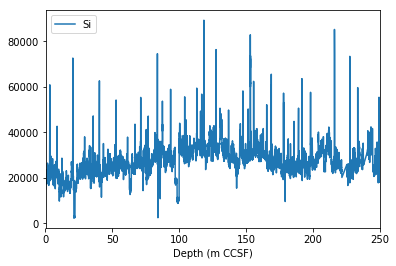

In [553]:
fig,ax=plt.subplots()
data[data['In Splice']==True].plot(x='Depth (m CCSF)',y='Si',ax=ax)

# Final Cleaning
## Select important columns

In [554]:
data['Depth (m CCSF)']=round(data['Depth (m CCSF)'].astype(float),2)
final=data[data['In Splice']==True].set_index('Depth (m CCSF)')

# Export

In [555]:
final['Exp']=361
final['Site']=final['Core'].str[:5]
final['Hole']=final['Core'].str[5]
final['Core']=final['Core'].str.split('_',expand=True)[1]
final['Type']=final['SectionLabel'].str[-2]
final['Section']=final['SectionLabel'].str[-1]
final['Top Offset (cm)']=final['position (mm)']/10

In [556]:
columns=['Exp', 'Site', 'Hole','Type', 'Section','SectionLabel','Section Top Depth (m CCSF)',
        'Section Bottom Depth (m CCSF)','Top Offset (cm)','filename', 'sample surface', 'validity', 'E-gain',
       'E-offset', 'F-slope', 'F-offset', 'cps', 'MSE', 'Al', 'Si',
         'S', 'Cl', 'Ar', 'K', 'Ca', 'Ti', 'Fe', 'Co', 'Ni',
         'Zn', 'Ga', 'Rb', 'Sr', 'Y', 'Zr', 'Rh', 'Pd', 'Cd', 'Sb',
         'Ce', 'Pr', 'Nd', 'Tb', 'Tm', 'Lu', 'Hf', 'Os', 'Ir', 'Pt', 'Hg',
       'Tl', 'Pb', 'Th', 'Pa', 'U', 'Cr kb', 'Ca ka-a sum', 'Ca ka-b sum',
       'S2', 'W la', 'W la scat', 'W lb1', 'W lb1 scat', 'W lb2', 'W lb2 scat',
       'Cr inc', 'Cr coh', 'Dt',]

In [557]:
final=final[columns]

In [558]:
results_path='/Users/danielbabin/Documents/GitHub/U1474_XRF_Data_Report/Data/'
table_path='/Users/danielbabin/Documents/GitHub/U1474_XRF_Data_Report/Tables/'
final.to_csv(results_path+'2cm_20s_xrf_data_counts.csv')
final.to_csv(table_path+'Table-5 2cm-20sec xrf data.csv')